IndexError: index 420 is out of bounds for axis 0 with size 420

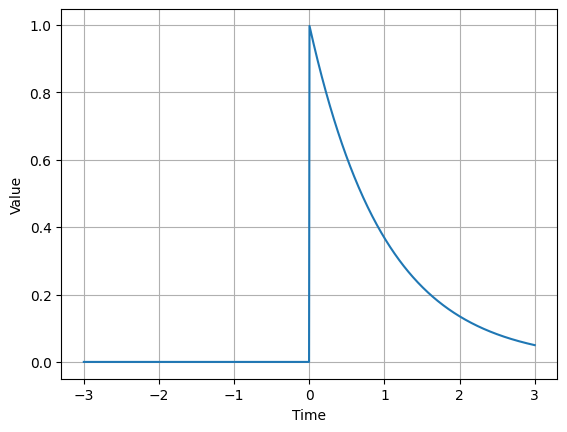

<Figure size 640x480 with 0 Axes>

Error in callback <function flush_figures at 0x0000023F226E3BA0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class ContinuousSignal:
    def __init__(self, func):
        self.func = func

    def get_value_at_time(self, time):
        # Get the value of the signal at a specific time
        return self.func(time)

    def add(self, other):
        # Define a method to add another signal to this one
        def add_func(x):
            return self.func(x) + other.func(x)
        new_signal = ContinuousSignal(add_func)
        return new_signal

    def shift_signal(self, shift):
        # Define a method to shift the signal by a specific amount
        def shifted_func(x):
            return self.func(x - shift)
        new_signal = ContinuousSignal(shifted_func)
        return new_signal

    def multiply(self, other):
        # Define a method to multiply this signal with another
        def multiplied_func(x):
            return self.func(x) * other.func(x)
        new_signal = ContinuousSignal(multiplied_func)
        return new_signal

    def multiply_const_factor(self, scaler):
        # Define a method to multiply the signal by a scalar factor
        def scaled_func(x):
            return self.func(x) * scaler
        new_signal = ContinuousSignal(scaled_func)
        return new_signal

    def plot(self, start, end, label):
        # Generate the x values for plotting
        x = np.linspace(start, end, 1000)
        # Get the corresponding y values by applying the signal function
        y = self.func(x)
        
        # Plot the signal with a label
        plt.plot(x, y, label=label)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.grid(True)

    @staticmethod
    def show():
        # Show all the plots
        plt.legend()
        plt.show()

# Define the unit impulse function separately
def unit_impulse(x):
    delta = 0.05
    impulse = np.zeros_like(x)  # Create an array of zeros with the same shape as x
    impulse[(x >= 0) & (x < delta)] = 1 / delta  # Set the impulse value where the condition is met
    return impulse


def unit_step(x):
    return np.where(x >= 0, 1, 0)


class LTI_Continuous:
    def __init__(self, impulse_response):
        self.impulse_response = impulse_response
        self.INF = 10

    def linear_combination_of_impulses(self, input_signal, delta):
        decomposed = []
        components = []
        shifts = []
        for i in np.arange(-self.INF, self.INF + 1, delta):
            coefficient = input_signal.get_value_at_time(i)
            # Create unit impulse
            impulse = ContinuousSignal(unit_impulse)
            # Shift the impulse by i amount
            shiftedImpulse = impulse.shift_signal(i)
            components.append(shiftedImpulse.multiply_const_factor(coefficient))
            shifts.append(i)
            decomposed.append((shiftedImpulse, coefficient, i))

        return decomposed, components, shifts

    def plot_components_subplots(self, components, shifts, final_output, fileName, delta):
        num_components = len(components)
        num_rows = (num_components + 4 - 1) // 4  # Ensure space for final output
        fig, axs = plt.subplots(num_rows, 4, figsize=(16, 4 * num_rows))
        axs = axs.flatten()  # Flatten to handle indexing easily

        for idx, (component, time_shift) in enumerate(zip(components, shifts)):
            x = np.linspace(-self.INF, self.INF, 1000)
            y = component.func(x)
            axs[idx].plot(x, y, label=f'h(x-{time_shift}) * x({time_shift})')
            axs[idx].set_xlabel('Time (x)')
            axs[idx].set_ylabel('Amplitude')
            axs[idx].legend()
            axs[idx].grid(True)

        # Plot the final output (sum of components) in the next available subplot
        x_final = np.linspace(-self.INF, self.INF, 1000)
        y_final = final_output.func(x_final)
        axs[num_components].plot(x_final, y_final, label='Output = Sum of Components')
        axs[num_components].set_title('Output = Sum')
        axs[num_components].set_xlabel('Time (x)')
        axs[num_components].set_ylabel('Amplitude')
        axs[num_components].legend()
        axs[num_components].grid(True)

        # Hide any unused subplots
        for j in range(num_components + 1, len(axs)):
            axs[j].axis('off')

        plt.tight_layout()
        plt.savefig(f"{fileName}.png")
        plt.show()

    def output_approx(self, signal, delta):
        result = ContinuousSignal(lambda x: 0)  # Zero function as the initial signal
        decomposed, components, shifts = self.linear_combination_of_impulses(signal, delta)
        
        # Compute the output as the sum of all scaled and shifted components
        for component in components:
            result = result.add(component)

        return result, components, shifts

def myFunc(x):
    return np.where(x > 0, np.exp(-x), 0)

def main():
    input_signal = ContinuousSignal(myFunc)
    input_signal.plot(-3, 3, "Input Signal")
    plt.savefig('cont_plots/input_signal.png')
    plt.figure()
    
    impulse_response = ContinuousSignal(unit_step)  # Use unit step as the impulse response

    LTI_system = LTI_Continuous(impulse_response)
    
    # Get the output and components
    output, components, shifts = LTI_system.output_approx(input_signal, 0.05)
    
    # Plot the components and final output in subplots
    LTI_system.plot_components_subplots(components, shifts, output, "cont_plots/output_signal", 0.05)

main()

